In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_csv(file):
    df = pd.read_csv(file, parse_dates=True, index_col=0)
    return df

## XGBoost for Decomposition + Kalman imputed dataset


In [3]:
y_true = pd.read_csv(r'output\/CompleteCovid.csv',index_col=0).Asia_confirmed_cases
y_true_train = y_true.loc['2020-01-22 09:00:00':'2020-02-26 02:00:00']
y_true_test =  y_true.loc['2020-02-26 02:30:00':]

X_train = read_csv('output/\CompleteCovidTrainDecompKalman_0.csv')
X_test = read_csv('output/\CompleteCovidTestDecompKalman_0.csv')

y_train = X_train.Asia_confirmed_cases
y_test = X_test.Asia_confirmed_cases

X_train = X_train.drop('Asia_confirmed_cases', axis=1)
X_test = X_test.drop('Asia_confirmed_cases', axis=1)


xgb_model = xgb.XGBClassifier(objective="reg:squarederror",
                                  eval_metric = 'rmse',
                                  max_depth=3,
                                  n_estimators=30,
                                  learning_rate=1
                              )
model = xgb_model.fit(X_train, y_train)

y_pred = model.predict(X_test)

MSE = mse(y_test, y_pred)
RMSE = np.sqrt(MSE)

print("\nRMSE: ", np.round(RMSE, 2))


y_true_test_reduced = pd.concat([y_true_test, y_test], axis=1).dropna().iloc[:, 0]
y_pred_reduced = pd.concat([y_true_test, pd.DataFrame(data=y_pred, index=y_true_test.index)], axis=1).dropna().iloc[:, 1]

MSE_real = mse(y_true_test_reduced, y_pred_reduced)
RMSE_real = np.sqrt(MSE_real)

print("\nRMSE with only real values: ", np.round(RMSE_real, 2))


RMSE:  4037.02

RMSE with only real values:  13802.29


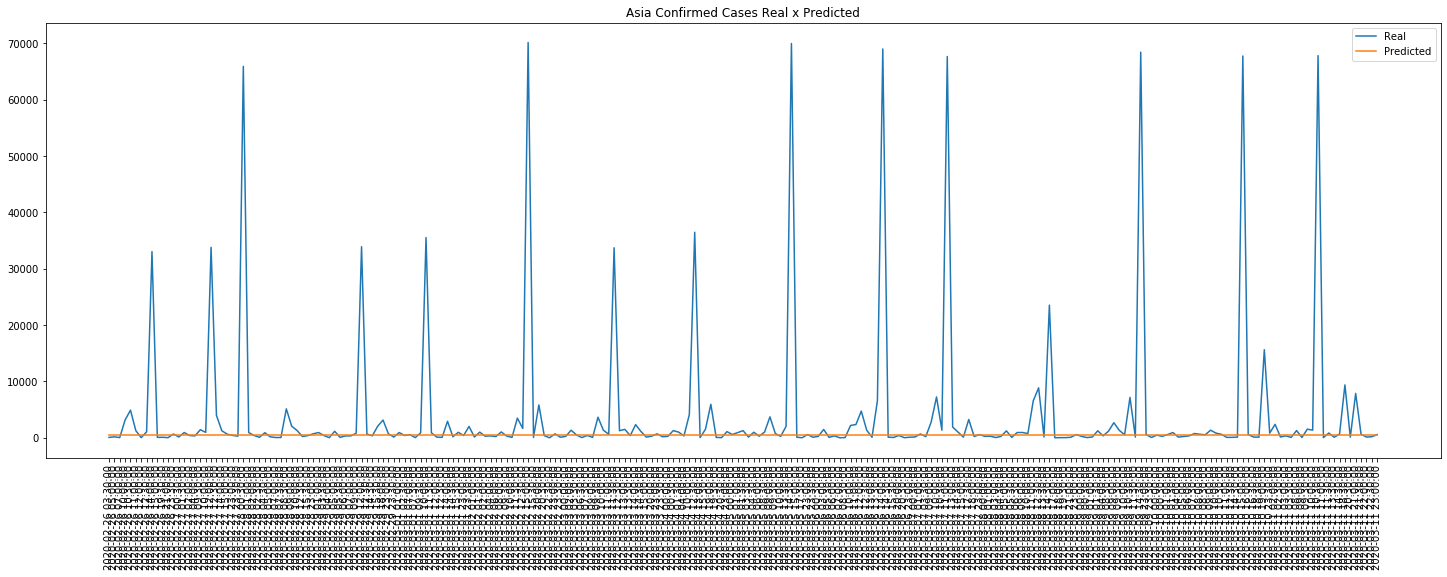

In [4]:
plt.figure(figsize=(25, 8))
plt.plot(y_true_test_reduced.index, y_true_test_reduced.values, label='Real')
plt.plot(y_pred_reduced.index, y_pred_reduced.values, label='Predicted')
plt.title("Asia Confirmed Cases Real x Predicted")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [5]:
def run_experiment_multiple_times(n=30):
    result_dict = {}
    result_dict= {'rmse':999999999999, 'true_rmse':999999999999, 'best_model':None, 'best_rmse':999999999999, 'best_true_rmse':999999999999}

    for i in range(0,n):
        y_true = pd.read_csv(r'output\/CompleteCovid.csv',index_col=0).Asia_confirmed_cases
        y_true_train = y_true.loc['2020-01-22 09:00:00':'2020-02-26 02:00:00']
        y_true_test =  y_true.loc['2020-02-26 02:30:00':]
        X_train = read_csv('output/\CompleteCovidTrainDecompKalman_'+str(i)+'.csv')
        X_test = read_csv('output/\CompleteCovidTestDecompKalman_'+str(i)+'.csv')
        
        y_train = X_train.Asia_confirmed_cases
        y_test = X_test.Asia_confirmed_cases
        
        xgb_model = xgb.XGBClassifier(objective="reg:squarederror",
                                          eval_metric = 'rmse',
                                          max_depth=3,
                                          n_estimators=30,
                                          learning_rate=1
                                      )
        model = xgb_model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        MSE = mse(y_test, y_pred)
        RMSE = np.sqrt(MSE)
        
        y_true_test_reduced = pd.concat([y_true_test, y_test], axis=1).dropna().iloc[:, 0]
        y_pred_reduced = pd.concat([y_true_test, pd.DataFrame(data=y_pred, index=y_true_test.index)], axis=1).dropna().iloc[:, 1]

        MSE_real = mse(y_true_test_reduced, y_pred_reduced)
        RMSE_real = np.sqrt(MSE_real)

        
        print('Round', i, "rmse", RMSE)
        result_dict['rmse'] += RMSE
        result_dict['true_rmse'] += RMSE_real
        if result_dict['best_rmse'] > RMSE:
            result_dict['best_rmse'] = RMSE
            result_dict['best_model'] = model
            result_dict['best_true_rmse'] = RMSE_real

    result_dict['rmse'] = result_dict['rmse']/n
    result_dict['true_rmse'] = result_dict['true_rmse']/n
    return result_dict     

In [ ]:
result_dict = run_experiment_multiple_times(n=30)

Round 0 rmse 4037.023379100421
Round 1 rmse 3433.1138809835015
Round 2 rmse 3177.0528079360006
Round 3 rmse 3014.3543971465083
Round 4 rmse 2896.718321641361
Round 5 rmse 2804.7704286749213
Round 6 rmse 2725.5476099643915
Round 7 rmse 2682.124564126252
Round 8 rmse 2646.9168065841036
Round 9 rmse 2630.3149318974483
Round 10 rmse 2599.964271481359
Round 11 rmse 2558.709772383626
Round 12 rmse 2525.846874402259
Round 13 rmse 2497.2651631017748
Round 14 rmse 2467.212744497317
Round 15 rmse 2435.867386330072


In [ ]:
result_dict